In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries, data, and functions

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
import mpl_toolkits.mplot3d as plt3d

from tensorflow.keras.layers import Dense,Reshape, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, UpSampling1D, Input

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

In [3]:
def side_lens(v):
  vx,vy,vz = np.array_split(v , 3)
  return [np.linalg.norm(vx-vy), np.linalg.norm(vy-vz), np.linalg.norm(vz-vx) ]
def normalize(x,x_min,x_max):
  return (x-x_min) / (x_max-x_min)


In [4]:
#Function which plots the 3D traingle

def Plot_2(v1, v2, v3, vv1, vv2, vv3):
  fig = plt.figure()
  fig.set_size_inches(5,5)
  ax = fig.add_subplot(111, projection='3d')
  
  X = np.array([v1,v2,v3])
  Y = np.array([vv1,vv2,vv3])
  
  l0x, ll0x = np.linspace(v1[0], v2[0], 50), np.linspace(vv1[0], vv2[0], 50)
  l1x, ll1x = np.linspace(v2[0], v3[0], 50), np.linspace(vv2[0], vv3[0], 50)
  l2x, ll2x = np.linspace(v3[0], v1[0], 50), np.linspace(vv3[0], vv1[0], 50)
  l0y, ll0y = np.linspace(v1[1], v2[1], 50), np.linspace(vv1[1], vv2[1], 50)
  l1y, ll1y = np.linspace(v2[1], v3[1], 50), np.linspace(vv2[1], vv3[1], 50)
  l2y, ll2y = np.linspace(v3[1], v1[1], 50), np.linspace(vv3[1], vv1[1], 50)
  l0z, ll0z = np.linspace(v1[2], v2[2], 50), np.linspace(vv1[2], vv2[2], 50)
  l1z, ll1z = np.linspace(v2[2], v3[2], 50), np.linspace(vv2[2], vv3[2], 50)
  l2z, ll2z = np.linspace(v3[2], v1[2], 50), np.linspace(vv3[2], vv1[2], 50)

  #Drawing lines
  ax.scatter(l0x, l0y, l0z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll0x, ll0y, ll0z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l1x, l1y, l1z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll1x, ll1y, ll1z, color='black', marker='s', s = 1, alpha = 0.1)
  ax.scatter(l2x, l2y, l2z, color='red', marker='s', s = 1, alpha = 0.1), ax.scatter(ll2x, ll2y, ll2z, color='black', marker='s', s = 1, alpha = 0.1)


  #plot the nodes
  for x, y, z in X:
    ax.scatter(x, y, z, color='red', marker='o', s=30)
  for x, y, z in Y:
    ax.scatter(x, y, z, color='black', marker='o', s=30)

  ax.scatter(0, 0, 0, color='blue', marker='s', s = 0.01 )
  ax.scatter(1, 0, 0, color='blue', marker='s', s = 0.01 )
  ax.scatter(0, 1, 0, color='blue', marker='s', s = 0.01 )
  ax.scatter(0, 0, 1, color='blue', marker='s', s = 0.01 )
  ax.scatter(1, 1, 1, color='blue', marker='s', s = 0.01 )

In [5]:
# Takes a triangle in column vector format, and randomly rotates and translate
def generate_triangle( positions ):

  p1,p2,p3 = positions.reshape((3,3))
  r = R.from_rotvec( 2*np.pi*np.random.rand(3) ) 
  t = np.random.rand(3)
  rotated_translated = np.concatenate( ( R.apply(r,p1),R.apply(r,p2),R.apply(r,p3)) ) + .5*np.array([t,t,t]).flatten()
  
  return rotated_translated

This cell is for importing larger datasets from google drive instead of remaking them.

In [6]:
DATA_SIZE = 300000
df = pd.read_csv('/content/drive/My Drive/Project/Autoencoder triangular molecule/training/training_size' + str(DATA_SIZE)+".csv")

In [7]:
# Loading the data into np arrays from dataframes
x_train = df.to_numpy()

# Splitting the array into validation, training, and test sets
x_train, x_val  = train_test_split(x_train, test_size = 0.1  , shuffle = False)
x_train, x_test = train_test_split(x_train, test_size = 1./9., shuffle = False)

x_train = x_train.astype('float')
x_val   = x_val  .astype('float')
x_test  = x_test .astype('float')

In [8]:
def loss_function_col(y_true, y_pred):

  bs = len(y_true)
  y_true, y_pred = tf.reshape(y_true, (bs,3,3)), tf.reshape(y_pred,(bs,3,3)) 

  perm_rows = tf.linalg.LinearOperatorPermutation([1,2,0])
  true_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_true, tf.matmul(perm_rows,y_true) ), axis=-1, keepdims=True))
  pred_dist = tf.sqrt(tf.reduce_sum(tf.math.squared_difference( y_pred, tf.matmul(perm_rows,y_pred) ), axis=-1, keepdims=True))

  return tf.square( tf.reduce_sum( tf.abs( tf.math.subtract(true_dist, pred_dist) ) , axis = 1)  )

### Loading the encoder, and decoder models


First off, I am going to investigate the encoder model which consists the input, 256-encoding layer, and the latent space. So the input is 9-coords and the output is 3 latent variables.

In [9]:
# Actual Model
model   = keras.models.load_model("/content/drive/MyDrive/Project/Custom_loss/Custom_Loss_Model",
                                compile=False)

input   = model.get_layer(index = 0)
l1      = model.get_layer(index = 1)
latent  = model.get_layer(index = 2)
l2      = model.get_layer(index = 3)
decode  = model.get_layer(index = 4)

#Building encoder
encoder = Sequential()
encoder.add(input)
encoder.add(l1)
encoder.add(latent)
encoder.summary()

#Building decoder
decoder = Sequential()
decoder.add(Flatten(input_shape=(3,)))
decoder.add(l2)
decoder.add(decode)
decoder.compile()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 256)               2560      
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 771       
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 2313      
Total params: 3,337
Trainable pa

# Encoder Model

### Exploring Latent Space


Note: nodes here are our latent variables which should contain a dimensionally reduced representation of the triangle.

In [ ]:
n      = 100000                  # Number samples
sample = np.random.rand( n, 9  ) # Generate sample triangles

In [ ]:
nodes = encoder.predict( sample )                          # Sample latent space 
lens  = np.array([side_lens(sample[i]) for i in range(n)]) # Contains actual side lenghts

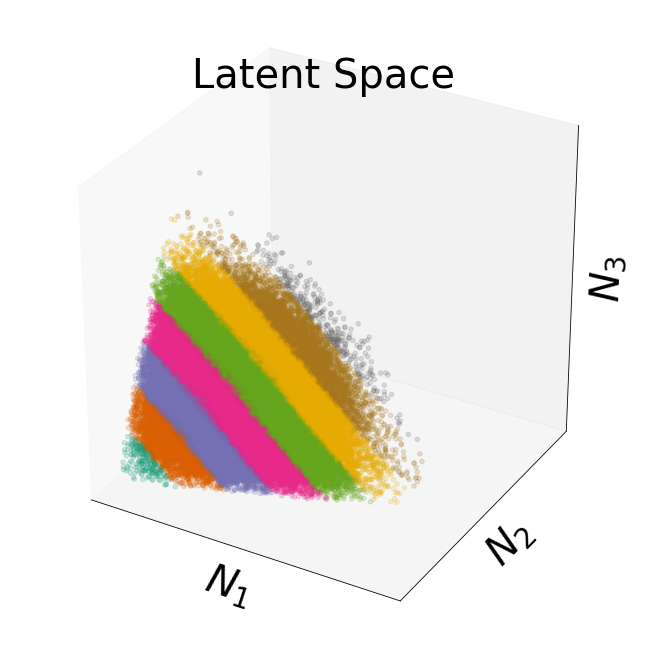

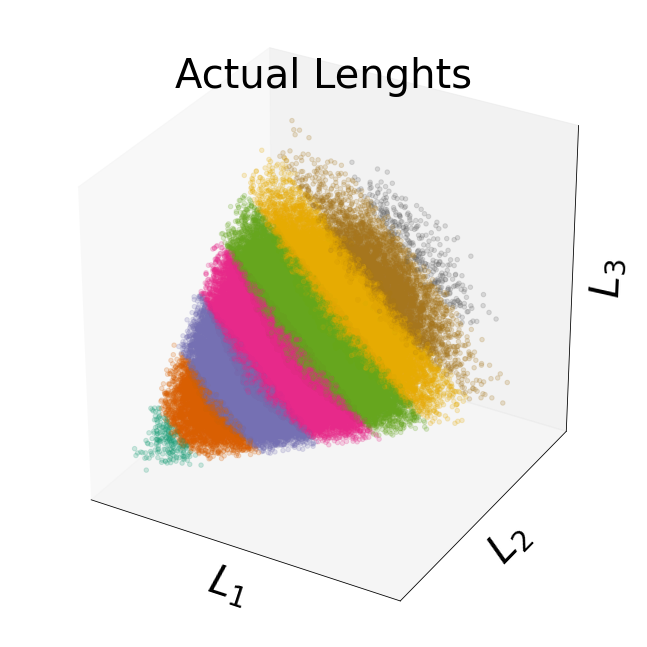

In [ ]:
size = 40

fig = plt.figure( figsize = (10,10) );  
matplotlib.rc('font', size=size)

tot_nodes = nodes[:,0] + nodes[:,1] + nodes[:,2]
tot_lens  =  lens[:,0] +  lens[:,1] +  lens[:,2]

color_map = normalize( tot_lens, np.min(tot_lens),np.max(tot_lens) )

ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter3D(nodes[:,0],nodes[:,1],nodes[:,2]
              , c=color_map,  cmap=plt.get_cmap('Dark2'),
                  alpha = 0.2, label = 'Node Value');
ax1.set_title('Latent Space',fontsize = size, pad = -30)

ax1.xaxis.set_tick_params(labelsize=30, pad = 10)
ax1.yaxis.set_tick_params(labelsize=30, pad = 10)
ax1.zaxis.set_tick_params(labelsize=30, pad = 10)
fig.subplots_adjust(wspace=0, hspace=0)

ax1.set_xlabel('$N_1$');
ax1.set_ylabel('$N_2$');
ax1.set_zlabel('$N_3$');

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.grid(False)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/encoded_3d', transparent=True,bbox_inches='tight')
plt.show()

###########################################

fig = plt.figure( figsize = (10,10) );  
ax2 = fig.add_subplot(111,projection='3d')
ax2.scatter3D( lens[:,0], lens[:,1], lens[:,2], 
                  c = color_map,  cmap=plt.get_cmap('Dark2'),
                  alpha = 0.2 , label = 'Actual Lens');

ax2.set_xlabel('$L_1$');
ax2.set_ylabel('$L_2$');
ax2.set_zlabel('$L_3$'); 
ax2.set_title('Actual Lenghts',fontsize = size, pad = -30)

ax2.xaxis.set_tick_params(labelsize=30, pad = 10)
ax2.yaxis.set_tick_params(labelsize=30, pad = 10)
ax2.zaxis.set_tick_params(labelsize=30, pad = 15)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.grid(False)

fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/input_3d', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
de_lens  = np.zeros_like(nodes)

#Sampling the latent space to see what comes out
decoded_vectors = decoder.predict(nodes)

for i in range(n):
  de_lens[i]  = side_lens( decoded_vectors[i] )  

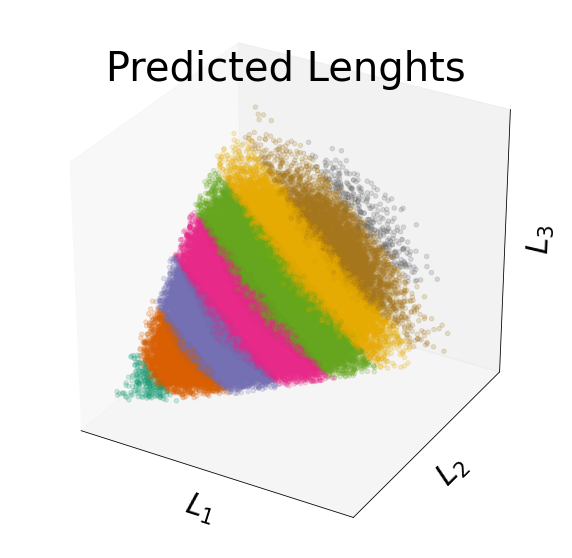

In [ ]:
fig = plt.figure( figsize = (10,10) );  

ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter3D(de_lens[:,0],de_lens[:,1],de_lens[:,2], 
              c=color_map,  cmap=plt.get_cmap('Dark2'),
                  alpha = .2, label = 'Node Value');
ax1.set_title('Predicted Lenghts',fontsize = size, pad = -30)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

ax1.set_zlabel('$L_3$',fontsize = 30); 
ax1.set_xlabel('$L_1$',fontsize = 30);
ax1.set_ylabel('$L_2$',fontsize = 30);
ax1.grid(False)

plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/decoded_3d', transparent=True, bbox_inches='tight')


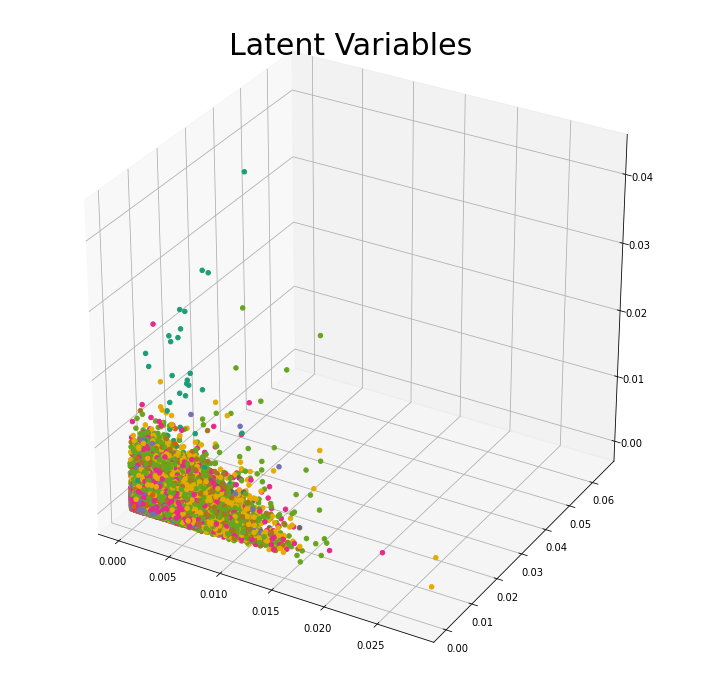

This plot of the 3 latent space variables, and 3 predicted side lenghts, with a colour mapping representing the norm of the total predicted lenght $\sqrt{l_1^2+l_2^2+l_3^2}$. There is clearly a relationship between the two clouds as the gradient follows a similar smooth pattern, corresponding to a change in the node value being proportional to a change in side lenght.

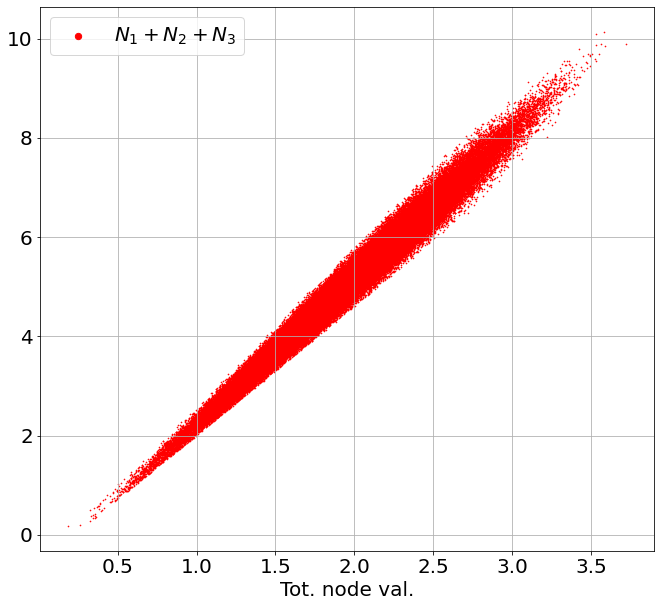

In [ ]:
tot_side_len = lens[:,0] + lens[:,1] + lens[:,2]
tot_node_len = nodes[:,0]+ nodes[:,1]+ nodes[:,2]

plt.figure( figsize = (10,10) ); 
ax = plt.axes()

ax.scatter(tot_side_len, tot_node_len, c ='r', s = 0.4, label = '$N_1+N_2+N_3$')
ax.legend(markerscale = 10)
ax.set_xlabel('Predicted side lenght'); 


Seems to be some limit on the sum of the nodes and also the sum of the lenghts.

A plot of actual side lenght against node value might be able to visualize a relation as you would expect that there would be some relationship between them.


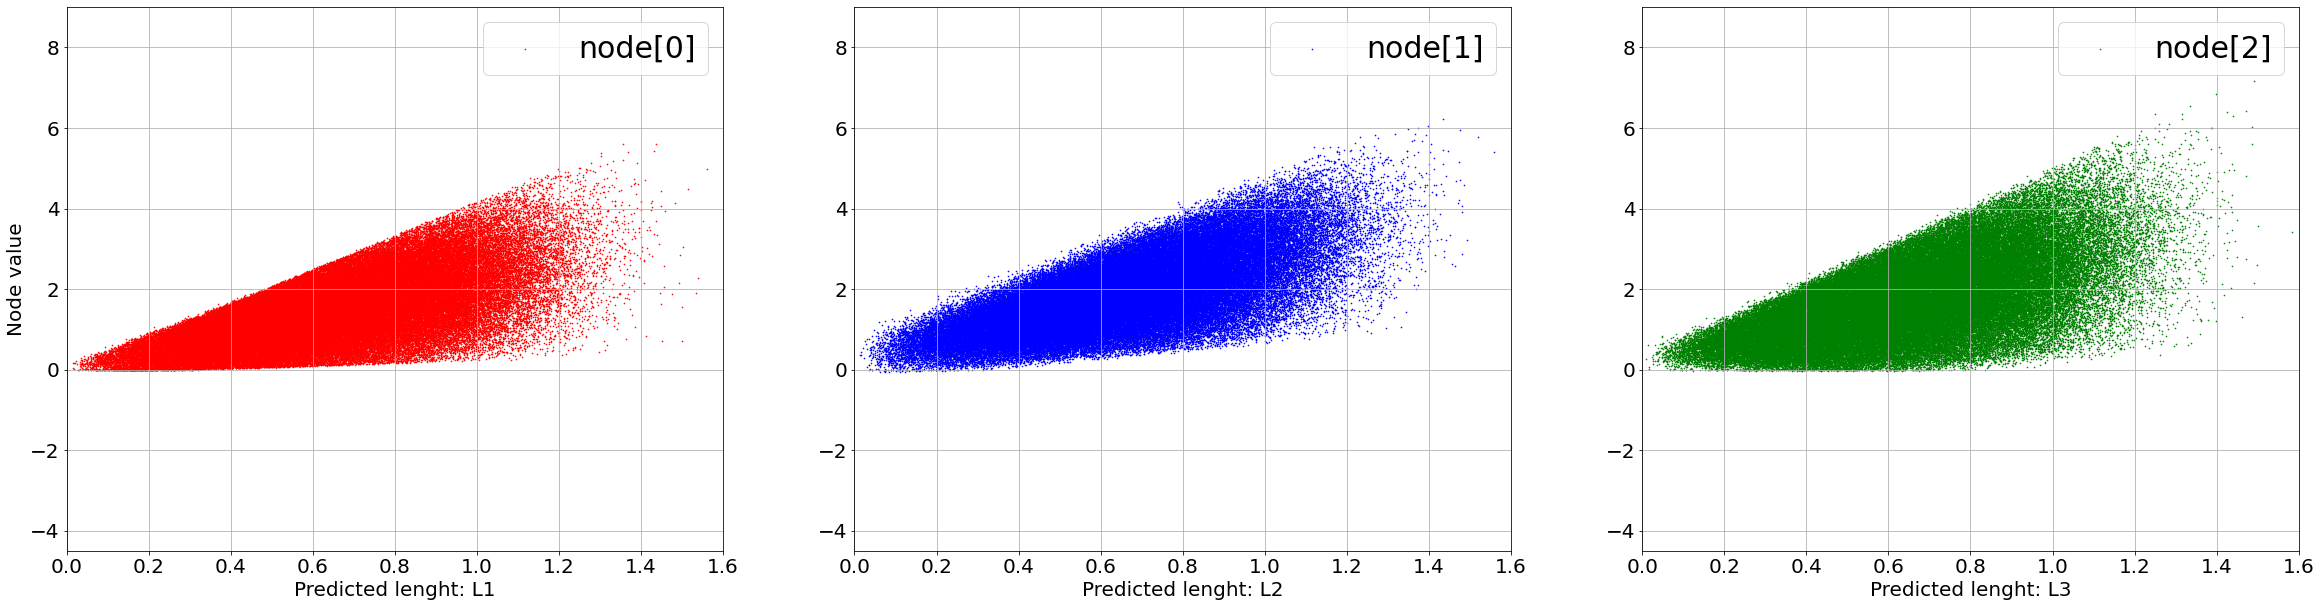

In [ ]:
xmin, xmax, ymin, ymax = 0, 1.6, -4.5, 9
plt.figure( figsize = (40,10) )

plt.subplot(1, 3, 1); plt.axis([xmin, xmax, ymin, ymax] ); plt.grid(); plt.xlabel('Predicted lenght: L1'); plt.ylabel('Node value');
plt.scatter(lens[:,0], nodes[:,0], c ='r', s = 0.4, label = 'node[0]');  plt.legend(fontsize = 30)

plt.subplot(1, 3, 2); plt.axis([xmin, xmax, ymin, ymax] ); plt.grid(); plt.xlabel('Predicted lenght: L2');
plt.scatter(lens[:,1], nodes[:,1], c ='b', s = 0.4, label = 'node[1]'); plt.legend(fontsize = 30)

plt.subplot(1, 3, 3); plt.axis([xmin, xmax, ymin, ymax] ); plt.grid(); plt.xlabel('Predicted lenght: L3');
plt.scatter(lens[:,2], nodes[:,2], c ='g', s = 0.4, label = 'node[2]');  plt.legend(fontsize = 30)
plt.show()

There seems like there is a correlation between the predicted side lenghts and the value of the latent variables as you might expect. however this does not look like an invarient representation. Perhaps I am looking at the data from the wrong direction, and maybe a change of basis would help clear things up.

Now, here I will play around with different linear combinations of the lenghts as the axes.

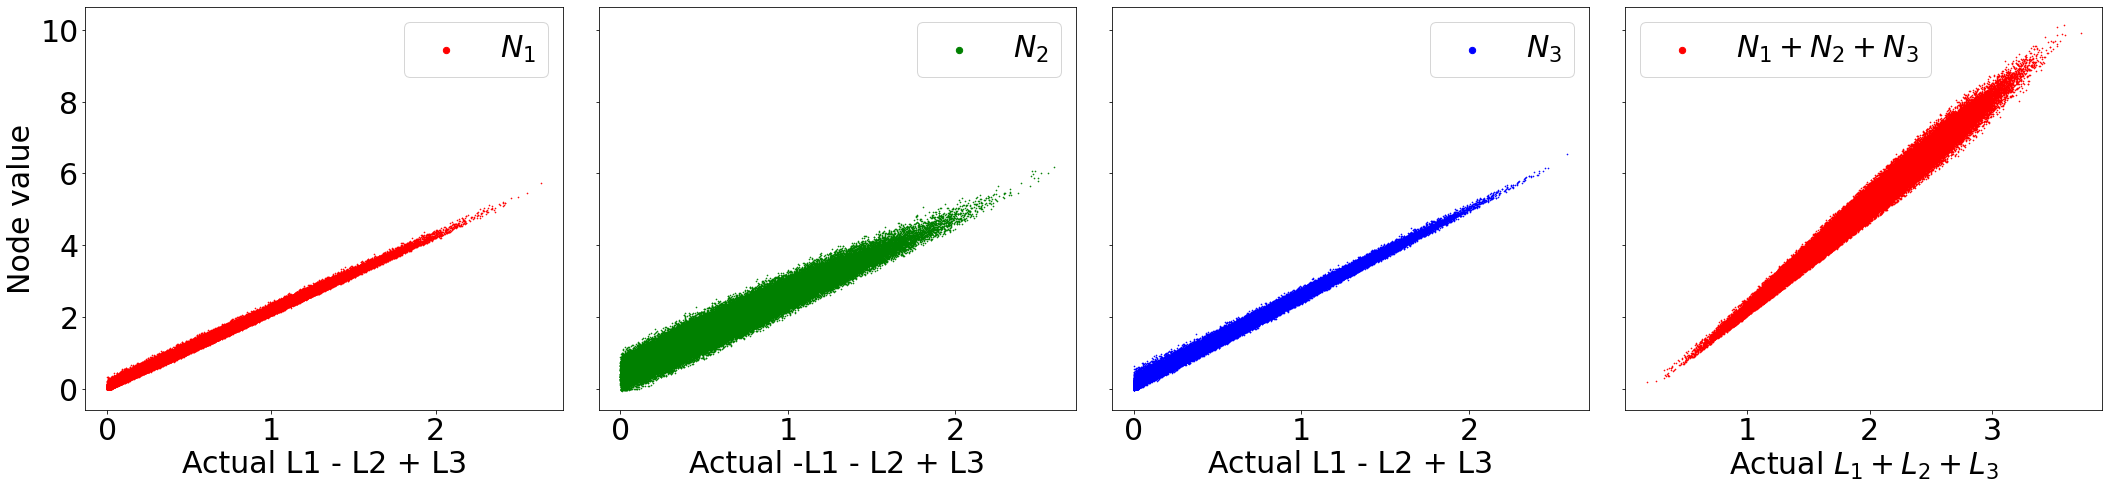

In [ ]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, sharey=True, figsize = (30,7.5))
matplotlib.rc('font', size=30)

tot_lens_1 = lens[:,0] + lens[:,1] - lens[:,2]
ax1.set_ylabel('Node value',fontsize=30); 
ax1.set_xlabel('Actual L1 - L2 + L3',fontsize=30)
ax1.scatter(tot_lens_1, nodes[:,0], c ='r', s = 0.4, label = '$N_1$'); 
ax1.legend(markerscale = 10)

tot_lens_2 =  -lens[:,0] + lens[:,1] + lens[:,2]
ax2.scatter(tot_lens_2, nodes[:,1], c ='g', s = 0.4, label = '$N_2$');
ax2.legend(markerscale = 10)
ax2.set_xlabel('Actual -L1 - L2 + L3',fontsize=30)

tot_lens_3 =  lens[:,0] - lens[:,1] + lens[:,2]
ax3.scatter(tot_lens_3, nodes[:,2], c ='b', s = 0.4, label = '$N_3$');
ax3.set_xlabel('Actual L1 - L2 + L3',fontsize=30)
ax3.legend(markerscale = 10)


tot_side_len = lens[:,0] + lens[:,1] + lens[:,2]
tot_node_len = nodes[:,0]+ nodes[:,1]+ nodes[:,2]
ax4.scatter(tot_side_len, tot_node_len, c ='r', s = 0.4, label = '$N_1+N_2+N_3$')
ax4.legend(markerscale = 10)
ax4.set_xlabel('Actual $L_1+L_2+L_3$',fontsize=30); 
fig.tight_layout()


plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/node_activations_vs_L', transparent=True, bbox_inches=0)
plt.show()

In [ ]:
from scipy.stats import linregress
r =linregress(tot_lens_1, nodes[:,0])
print(linregress(tot_lens_1, nodes[:,0]), '\n',
      linregress(tot_lens_2, nodes[:,1]), '\n',
      linregress(tot_lens_3, nodes[:,2]) )

LinregressResult(slope=2.1210951145664607, intercept=0.06845385799205728, rvalue=0.9970372360178706, pvalue=0.0, stderr=0.0005174813686278355) 
 LinregressResult(slope=2.1991109559567055, intercept=0.4454147713749992, rvalue=0.9683424934691713, pvalue=0.0, stderr=0.0017927147082406744) 
 LinregressResult(slope=2.4693365065489608, intercept=0.12770129965758015, rvalue=0.9963370033442758, pvalue=0.0, stderr=0.0006702140832371527)


In [ ]:
r

LinregressResult(slope=2.1210951145664607, intercept=0.06845385799205728, rvalue=0.9970372360178706, pvalue=0.0, stderr=0.0005174813686278355)



This is an interesting result that shows that linear combinations of lenghts, and the nodes are linearly related by 
$$
\textit{Node}_1 = 3.80(+L_1-L_2+L_3) + 0.08
$$
$$ 
\textit{Node}_2 = 1.66(-L_1-L_2+L_3) - 0.77
$$
$$ 
\textit{Node}_3 = 3.75(-L_1+L_2+L_3) + 0.19
$$
The N_2 node is not as correlated as the other two, with R = 0.89 as opposed to R=0.99 for the other two.



Now to try see what linear combinations of the node values give.

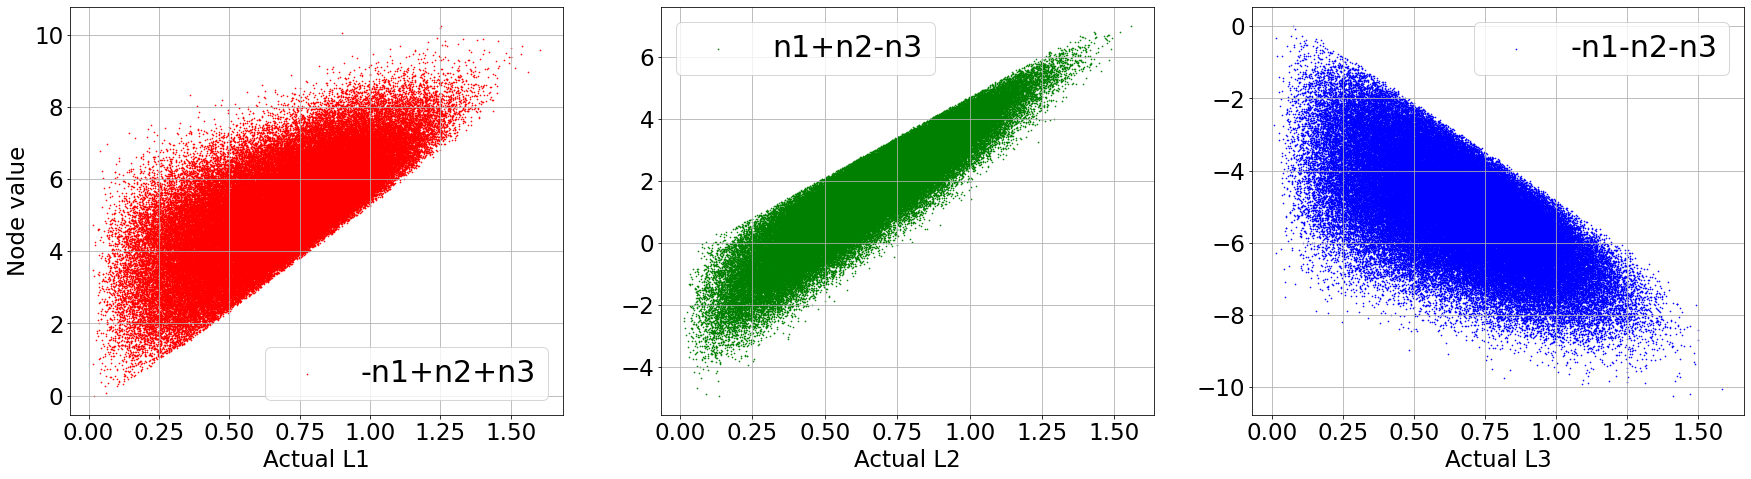

In [ ]:
xmin, xmax, ymin, ymax = 0, 1.6, -4.5, 9
plt.figure( figsize = (30,7.5) )

tot_node_1 = nodes[:,0] + nodes[:,1] + nodes[:,2]
plt.subplot(1, 3, 1); plt.ylabel('Node value'); plt.grid(); plt.xlabel('Actual L1')
plt.scatter(lens[:,0], tot_node_1, c ='r', s = 0.4, label = '-n1+n2+n3'); plt.legend(loc = 'best',fontsize = 30)

tot_node_2 = nodes[:,0] + nodes[:,1] - nodes[:,2]
plt.subplot(1, 3, 2); plt.grid();plt.xlabel('Actual L2')
plt.scatter(lens[:,1], tot_node_2, c ='g', s = 0.4, label = 'n1+n2-n3'); plt.legend(loc = 'best',fontsize = 30)

tot_node_3 = -nodes[:,0] - nodes[:,1] - nodes[:,2]
plt.subplot(1, 3, 3); plt.grid(); plt.xlabel('Actual L3')
plt.scatter(lens[:,2], tot_node_3, c ='b', s = 0.4, label = '-n1-n2-n3'); plt.legend(loc = 'best',fontsize = 30)

plt.show()

In [ ]:
r =linregress(tot_lens_1, nodes[:,0])
print(linregress(lens[:,0], tot_node_1), '\n',
      linregress(lens[:,1], tot_node_2), '\n',
      linregress(lens[:,2], tot_node_3)       )

LinregressResult(slope=4.193696828843122, intercept=2.358052029082869, rvalue=0.7307543392707332, pvalue=0.0, stderr=0.01238859462141755) 
 LinregressResult(slope=6.2991438385889165, intercept=-2.556661708439333, rvalue=0.915766865006519, pvalue=0.0, stderr=0.008738034476845083) 
 LinregressResult(slope=-3.705841522421061, intercept=-2.679187036740632, rvalue=-0.6460419998756455, pvalue=0.0, stderr=0.013846077423016145)




This is an interesting result that shows that linear combinations of lenghts, and the nodes are linearly related by 
$$
\textit{L}_1 = -8.43(-n_1+n_2+n_3) + 3.78
$$
$$ 
\textit{L}_2 = -8.31(+n_1+n_2-n_3) + 3.53
$$
$$ 
\textit{L}_3 = -8.69(-n_1-n_2-n_3) + 2.35
$$
Using these formulae the side lenght given an input node can be estimated. This might be the operation the machine is carrying out. When the model is optimally trained, these functions probably converge. Would it be possible to take



### Invarient representation?

So my idea here is to 

1.   Generate random triangles
2.   Translate and rotate those triangles
3.   Encode triangles into LS

If the same triangles are encoded into the same area of the LS, an invarient representation has been created.



In [10]:
#Using the encoder model to generate predictions on the test set

samples = 1000 # number of triangles
n       = 500   # number of times each triangle was sampled

random_vecs = ( np.random.rand( samples, 9 ) )
sample_vecs = np.zeros( (samples, n, 9) )

for i in range(samples):
  for j in range(n):
    sample_vecs[i][j] = generate_triangle( random_vecs[i] )

nodes_sam = np.array([ encoder.predict(sample_vecs[i]) for i in range(samples) ])

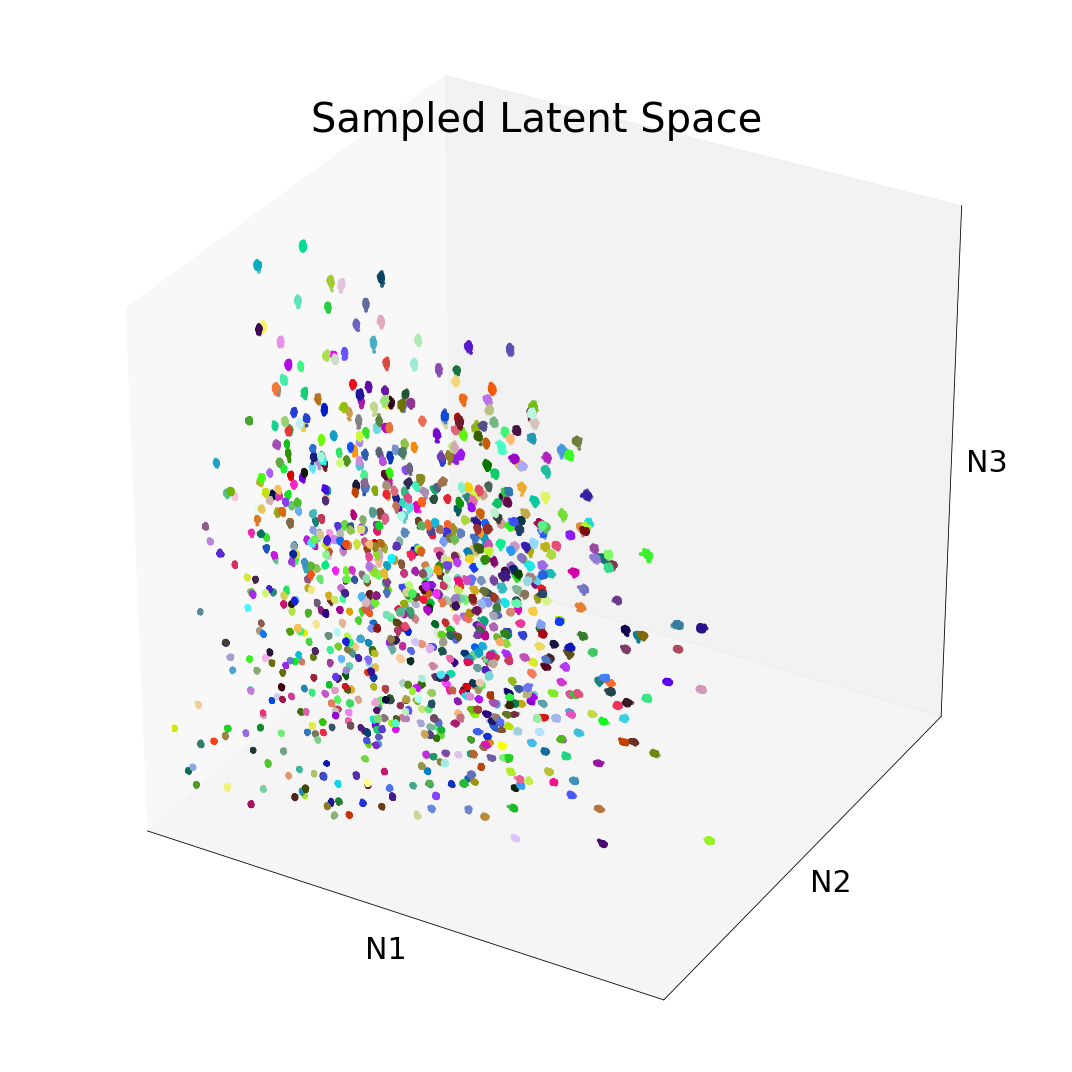

In [19]:
fig = plt.figure( figsize = (15,15) );  

ax1 = fig.add_subplot(111,projection='3d')
cmap = plt.cm.get_cmap("rainbow", n+1)
for i in range(samples):
  c=cmap(i)
  ax1.scatter3D(nodes_sam[i,:,0],nodes_sam[i,:,1],nodes_sam[i,:,2],
                 s = 8, c = [np.random.rand(3)])

ax1.set_xlabel('N1', fontsize=30); 
ax1.set_ylabel('N2', fontsize=30); 
ax1.set_zlabel('N3', fontsize=30);

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

plt.title('Sampled Latent Space',fontsize = 40, pad = -40)

ax1.set_xlim3d(0,5); ax1.set_ylim3d(0,5); ax1.set_zlim3d(0,5)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/sampled_lat', transparent=True, bbox_inches = 'tight')

plt.show()

The colors here represent activations of the 3 nodes of the same triangle (but randomly rotated and translated).

Same colors are grouped together in patches, meaning same triangles are encoded in the same place in latent space.

# Decoder Model

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 2313      
Total params: 3,337
Trainable params: 3,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n = 500000
a = 4
# Randomly Sampling the latent space using random nodes in the interval [-a,a]
nodes = a*np.random.random_sample(size = (n,3,))
lens  = np.zeros_like(nodes)

#Sampling the latent space to see what comes out
decoded_vectors = decoder.predict(nodes)

for i in range(n):
  lens[i]  = side_lens( decoded_vectors[i] )  

Now im going to try sample the latent space by giving the nodes a range values and seeing what comes out.

<Figure size 1440x720 with 0 Axes>

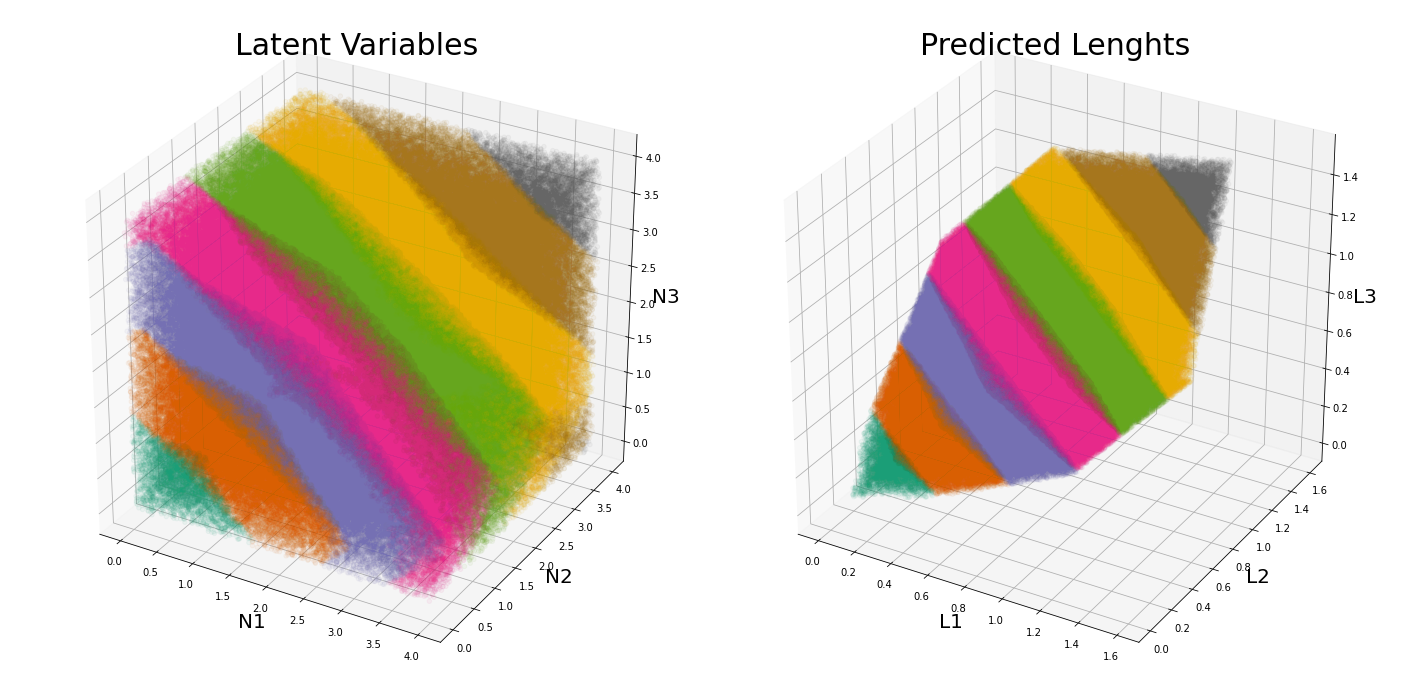

In [ ]:
fig = plt.figure( figsize = (20,10) );  

fig = plt.figure( figsize = (20,10) );  
matplotlib.rc('font', size=20)

tot_nodes = nodes[:,0] + nodes[:,1] + nodes[:,2]
tot_lens  =  lens[:,0] +  lens[:,1] +  lens[:,2]

color_map = normalize( tot_lens, np.min(tot_lens),np.max(tot_lens) )

ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter3D(nodes[:,0],nodes[:,1],nodes[:,2], 
                  zdir = 'x', c=color_map,  cmap=plt.get_cmap('Dark2'),
                  alpha = 0.05, label = 'Node Value');
ax1.set_title('Latent Variables',fontsize = 30)

ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)
ax1.zaxis.set_tick_params(labelsize=10)

plt.tight_layout()

ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter3D( lens[:,0], lens[:,1], lens[:,2], 
                  zdir = 'x', 
                  c = color_map,  cmap=plt.get_cmap('Dark2'),
                  alpha = 0.05 , label = 'Actual Lens');

ax1.set_xlabel('N1');ax1.set_ylabel('N2');ax1.set_zlabel('N3');
ax2.set_xlabel('L1');ax2.set_ylabel('L2');ax2.set_zlabel('L3'); 
ax2.set_title('Predicted Lenghts',fontsize = 30)

ax2.xaxis.set_tick_params(labelsize=10)
ax2.yaxis.set_tick_params(labelsize=10)
ax2.zaxis.set_tick_params(labelsize=10)

fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig('/content/drive/MyDrive/Symmester 2/Final year project/Writeup/Diagrams/Latent_actual_decoder', transparent=True)
plt.show()

To interpret this we note that same colors to eachother. So the dark spike on the predicted lenghts plot corrosponds to node activations from highly negative node activations ie: N1,N2,N3 = -10,-10,-10

NameError: ignored

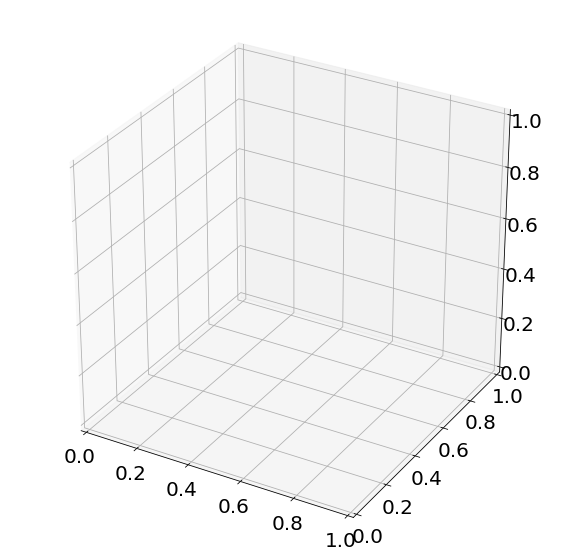

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,10)
ax = fig.add_subplot(111, projection='3d')
for j in range(100000):
#  Plot_2(  encoded_v1[i],   encoded_v2[i],   encoded_v3[i], 
#         encoded_v1[i+1], encoded_v2[i+1], encoded_v3[i+1])
  l = side_lens(np.array([encoded_v1[j], encoded_v2[j], encoded_v3[j]]).flatten())
  angles = [np.arccos( (l[i]**2+l[(i+1)%3]**2-l[(i+2)%3]**2)/(2*l[i]*l[(i+1)%3]) ) for i in range(3) ] 
  ax.scatter(angles[0],angles[1],angles[2], c ='r')
plt.show()